In [62]:
import pandas as pd
from gwpy.timeseries import TimeSeries
import pycbc
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy import stats

We load the CSV that contains all glitch times from the first half of the third observing run.

In [5]:
glitches = pd.read_csv('O3a_allifo.csv')
glitches.columns

Index(['GPStime', 'peakFreq', 'snr', 'amplitude', 'centralFreq', 'duration',
       'bandwidth', 'chisq', 'chisqDof', 'confidence', 'id', 'ifo', 'label',
       'imgUrl', 'Q-value'],
      dtype='object')

As you can see it contains a bunch of columns. 
- **GPStime**: The timestamp in GPS format indicating the event time.
- **peakFreq**: The frequency at which the signal has the highest intensity.
- **snr**: Signal-to-noise ratio, indicating the clarity of the signal.
- **amplitude**: The strength or height of the signal wave.
- **centralFreq**: The central frequency of the signal's spectral content.
- **duration**: The time span of the signal event.
- **bandwidth**: The range of frequencies covered by the signal.
- **chisq**: The chi-squared statistic for assessing signal fit quality.
- **chisqDof**: The degrees of freedom used in the chi-squared test.
- **confidence**: The likelihood or certainty of the detection.
- **id**: A unique identifier for the signal event.
- **ifo**: The interferometer associated with the signal detection.
- **label**: Classification or annotation of the event.
- **imgUrl**: Link to an image or visual representation of the signal.
- **Q-value**: Quality factor indicating the sharpness of the signal.

Let's take a look at the **label** column to see all the different glitch classes.

In [7]:
glitches['label'].unique()

array(['Extremely_Loud', 'Scattered_Light', 'Scratchy', 'Power_Line',
       'Koi_Fish', 'Whistle', 'Low_Frequency_Burst', 'Tomte',
       'Repeating_Blips', 'Fast_Scattering', 'Blip', 'Blip_Low_Frequency',
       'Violin_Mode', 'Helix', 'None_of_the_Above', 'Low_Frequency_Lines',
       'Wandering_Line', 'No_Glitch', 'Air_Compressor', 'Chirp',
       'Light_Modulation', 'Paired_Doves', '1400Ripples', '1080Lines'],
      dtype=object)

As a dummy example let's select 'Tomte' glitches from LIGO Livingston (L1)

In [11]:
selected = glitches[(glitches['label'] == 'Tomte') & (glitches['ifo'] == 'L1')]
len(selected), len(selected)

(20804, 20804)

In [28]:
np.round(np.mean(selected['duration'].values), 2)

0.66

You can see that 'Tomte' of 'L1' is a subset of the initial data set. How long are they?

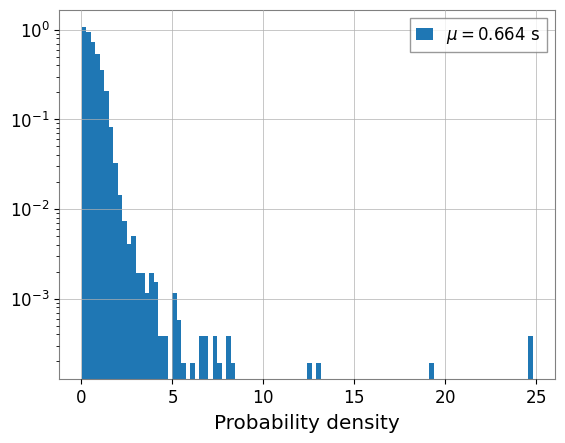

In [31]:
plt.hist(selected['duration'].values, bins=100, density=True,
         label=f'$\mu=$'+str(np.round(np.mean(selected['duration'].values), 3))+' s')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.xlabel('Probability density')
plt.legend()

On average they are 0.664 s long, so we can visualize then in 2s. Let's pick a random example and visualize it.

In [43]:
g_star = selected['GPStime'].iloc[0]
tw = 3 # time window per side. 
srate = 4096 # sampling rate
ifo = 'L1'
noise = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
noise = noise.to_pycbc()
white_noise, psd = noise.whiten(len(noise) / (2 * srate),
                                len(noise)/( 4 * srate),
                                remove_corrupted = False,
                                return_psd = True)
# we crop 1s at each side to avoid border effects
white_noise = white_noise[int(srate * 1):-int(srate * 1)]

/home/melissa.lopez/.conda/envs/gengli_env/lib/python3.9/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '


(1.5, 2.5)

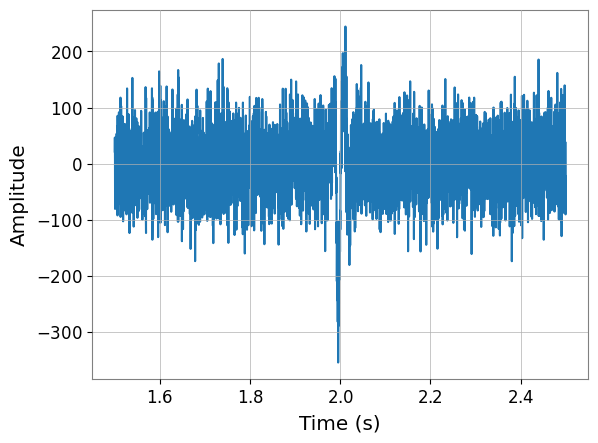

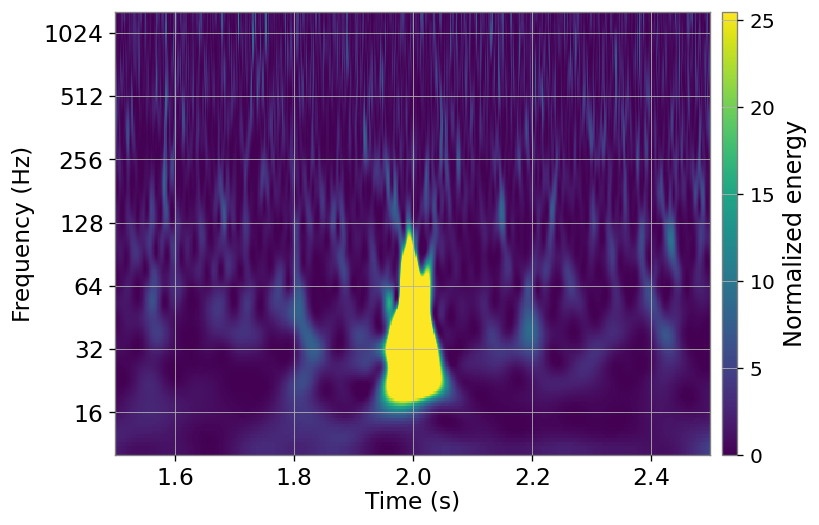

In [61]:
data = TimeSeries(white_noise, sample_rate = srate)
# Q-transform with Gravity Spy standards
# Note that here we set whiten to FALSE because we whitened in the previous cell
q_scan = data.q_transform(qrange=[4,64], frange=[10, 2048],
                          tres=0.002, fres=0.5, whiten=False)

# We crop the time series to make it similar time range to spectrogram
t = data.times[int(srate * 1.5):-int(srate * 1.5)]
y = data.value[int(srate * 1.5):-int(srate * 1.5)]
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# We plot according to Gravity Spy standards
fig, ax  = plt.subplots(dpi=120)
ax.imshow(q_scan, cmap='viridis')
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=14)
ax.set_xlabel('Time (s)', labelpad=0.1,  fontsize=14)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(axis ='both', which ='major', labelsize = 14)
cb = ax.colorbar(label='Normalized energy',clim=[0, 25.5])
ax.set_xlim(1.5, 2.5)

OK, now we can check its Gaussianity with Saphiro test. We test that the input time series (y) is Gaussian, against the alternative hypothesis that it is non-Gaussian. If the test yields a p-value below $\alpha=0.05$ it means that the input data is non-Gaussian

In [66]:
res = stats.shapiro(y)
res.pvalue

6.604808889386861e-17

As we can see the p-value is very small, so this input data is non-Gaussian. When we extract a glitch the residual background should be Gaussian as we extract all the structure (the glitch) from the input. However, are all glitches Gaussian? Generalize for all glitch classes of L1. What 